In [39]:
from collections import deque
from datasets import load_dataset
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import spacy
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig

## Setup
Loading in model (we use GPT-2)

In [14]:
model_name = "gpt2"
config = AutoConfig.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, config=config)
nlp = spacy.load("en_core_web_sm")

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [7]:
def get_sentence_token_spans(text, tokenizer):
    """
    Splits text into sentences and maps them to token ranges.
    Returns: List of (sentence_text, start_token_idx, end_token_idx)
    """
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]

    # Tokenize the full text with offsets to align
    inputs = tokenizer(text, return_tensors="pt", return_offsets_mapping=True)
    offset_mapping = inputs.offset_mapping[0].numpy() # (num_tokens, 2)

    sent_spans = []
    current_sent_idx = 0

    # Simple alignment: Find which tokens fall into the char range of the sentence
    # Note: This is a greedy alignment; production code needs robust char-to-token mapping
    char_cursor = 0
    for sent in sentences:
        start_char = text.find(sent, char_cursor)
        end_char = start_char + len(sent)
        char_cursor = end_char

        # Find tokens that overlap with this sentence range
        sent_token_indices = []
        for i, (start, end) in enumerate(offset_mapping):
            # Check overlap
            if start >= start_char and end <= end_char:
                sent_token_indices.append(i)

        if sent_token_indices:
            sent_spans.append({
                "text": sent,
                "start": sent_token_indices[0],
                "end": sent_token_indices[-1]
            })

    return inputs, sent_spans

Tester for the above code

In [8]:
text = (
    "The CPU handles the instructions. "
    "The RAM stores the data temporarily. "
    "However, the GPU is needed for rendering images. "
    "Together, these components power the computer. "
    "The user interacts via the keyboard."
)

inputs, sent_data = get_sentence_token_spans(text, tokenizer)
print(f"Detected {len(sent_data)} sentences.")

Detected 5 sentences.


The below code runs the model once, extracts the attention, and then changes the attention from a (tokens x tokens) matrix to the sentence matrix (sentences x sentences).

In [15]:
def extract_sentence_dependency_matrix(model, inputs, sent_data, agg_method='mean'):
    """
    Runs the model and aggregates token-level attention into sentence-level attention.
    """
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # outputs.attentions is a tuple of (num_layers) tensors of shape (batch, heads, seq, seq)
    # We will average across all layers and heads for a 'global' attention view.
    # You could also target specific 'induction heads' if you wanted to be fancy.

    # Stack layers -> (layers, batch, heads, seq, seq)
    all_attentions = torch.stack(outputs.attentions)

    # Average over layers and heads -> (seq, seq)
    # Squeeze batch dimension (0)
    avg_attention = all_attentions.mean(dim=(0, 2)).squeeze(0).cpu().numpy()

    n_sentences = len(sent_data)
    sent_attn_matrix = np.zeros((n_sentences, n_sentences))

    for i in range(n_sentences): # Query Sentence (The one 'looking back')
        for j in range(n_sentences): # Key Sentence (The one being looked at)

            # Get token ranges
            q_start, q_end = sent_data[i]['start'], sent_data[i]['end']
            k_start, k_end = sent_data[j]['start'], sent_data[j]['end']

            # Extract sub-matrix for these two sentences
            # Note: causal masking means attn is 0 if k > q, handled naturally by the model
            sub_matrix = avg_attention[q_start:q_end+1, k_start:k_end+1]

            if sub_matrix.size > 0:
                if agg_method == 'max':
                    score = np.max(sub_matrix)
                elif agg_method == 'mean':
                    score = np.mean(sub_matrix)
                elif agg_method == 'sum':
                    score = np.sum(sub_matrix)

                sent_attn_matrix[i, j] = score

    return sent_attn_matrix

In [16]:
attn_matrix = extract_sentence_dependency_matrix(model, inputs, sent_data, agg_method='mean')

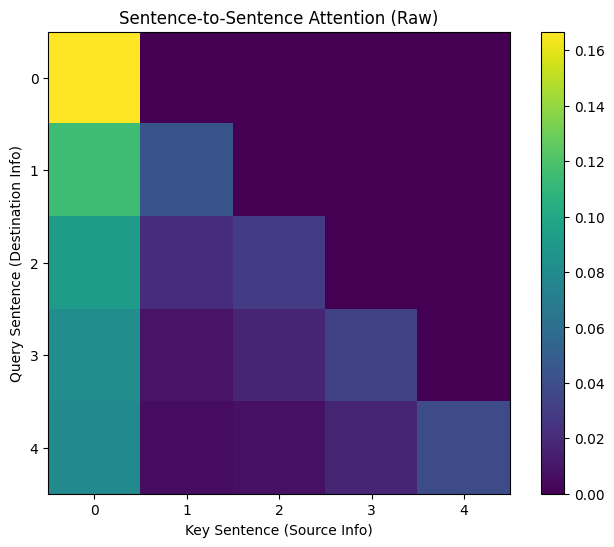

In [32]:
# Visualization of Sentence Attention
plt.figure(figsize=(8, 6))
plt.imshow(attn_matrix, cmap='viridis')
plt.title("Sentence-to-Sentence Attention (Raw)")
plt.xlabel("Key Sentence (Source Info)")
plt.ylabel("Query Sentence (Destination Info)")
plt.colorbar()
plt.show()

Now, we construct the DAG of the attentions. In this DAG, there's an edge between two sentences if the attention is above some certain threshold. This is because any two sentences will likely have some small attention, so we only want to filter for sentence pairs that are highly important to each other.

In [33]:
def generate_permutations(sent_data, attn_matrix, quantile_threshold=0.2, n_samples=5):
    """
    Builds the dependency DAG and samples 'n_samples' unique permutations.
    """
    G = nx.DiGraph()
    n = len(sent_data)

    # 1. Add Nodes
    for i in range(n):
        G.add_node(i, text=sent_data[i]['text'])

    # 2. Determine Threshold
    lower_triangle = attn_matrix[np.tril_indices(n, k=-1)]
    if len(lower_triangle) > 0:
        cutoff = np.quantile(lower_triangle, quantile_threshold)
    else:
        cutoff = 0.0

    # 3. Add Edges (Pruning weak attention)
    # Edge j -> i means i depends on j
    for i in range(n): # Later sentence
        for j in range(i): # Earlier sentence
            if attn_matrix[i, j] > cutoff:
                G.add_edge(j, i)

    # 4. Sample Permutations
    unique_permutations = set()
    attempts = 0
    max_attempts = n_samples * 5 # Stop if we can't find enough unique ones

    # Add the original sequence as the first baseline "permutation"
    original_seq = tuple(range(n))
    unique_permutations.add(original_seq)

    while len(unique_permutations) < (n_samples + 1) and attempts < max_attempts:
        # Call the internal sampler
        new_perm = sample_topological_sort(G)
        unique_permutations.add(tuple(new_perm))
        attempts += 1

    # Convert sets of tuples back to lists
    results = [list(p) for p in unique_permutations]

    return G, results

Since there's $O(n!)$ possible permutations, we limit the permutations we use to some random sample of all valid topological ordering of the vertices of the DAG.

In [34]:
def sample_topological_sort(G):
    """
    Generates a single random topological sort of a DAG using
    Randomized Kahn's Algorithm.

    Args:
        G: A NetworkX DiGraph.
    Returns:
        A list of node indices representing a valid permutation.
    """
    in_degree = {u: d for u, d in G.in_degree() if d > 0}

    # Initialize queue with nodes having 0 in-degree (no dependencies)
    zero_in_degree_queue = [n for n in G.nodes() if G.in_degree(n) == 0]

    sorted_order = []

    while zero_in_degree_queue:
        # Pick a random candidate from the available "next steps"
        candidate_idx = random.randrange(len(zero_in_degree_queue))
        current_node = zero_in_degree_queue.pop(candidate_idx)

        sorted_order.append(current_node)

        # 'Virtual' removal of the node: update neighbor in-degrees
        for neighbor in G.successors(current_node):
            in_degree[neighbor] -= 1
            if in_degree[neighbor] == 0:
                zero_in_degree_queue.append(neighbor)
                del in_degree[neighbor]

    # Cycle detection fallback
    if len(sorted_order) != len(G.nodes()):
        # This usually means the graph had a cycle.
        # Fallback: return the nodes sorted by their original index (0, 1, 2...)
        return sorted(list(G.nodes()))

    return sorted_order

In [35]:
dag, permutations = generate_permutations(
    sent_data,
    attn_matrix,
    quantile_threshold=0.5,
    n_samples=3
)

print(f"Generated {len(permutations)} unique sequences (including original).\n")

Generated 4 unique sequences (including original).



Printing out 3 examples of the generated sentences:

In [36]:
for i, perm in enumerate(permutations[:3]):
    print(f"--- Permutation {i+1} ---")
    reconstructed_text = " ".join([sent_data[idx]['text'] for idx in perm])
    print(reconstructed_text)
    print("")

--- Permutation 1 ---
The CPU handles the instructions. Together, these components power the computer. The user interacts via the keyboard. The RAM stores the data temporarily. However, the GPU is needed for rendering images.

--- Permutation 2 ---
The CPU handles the instructions. The RAM stores the data temporarily. However, the GPU is needed for rendering images. Together, these components power the computer. The user interacts via the keyboard.

--- Permutation 3 ---
The CPU handles the instructions. The RAM stores the data temporarily. However, the GPU is needed for rendering images. The user interacts via the keyboard. Together, these components power the computer.



Here's a visualization of what the DAG looks like for this example.

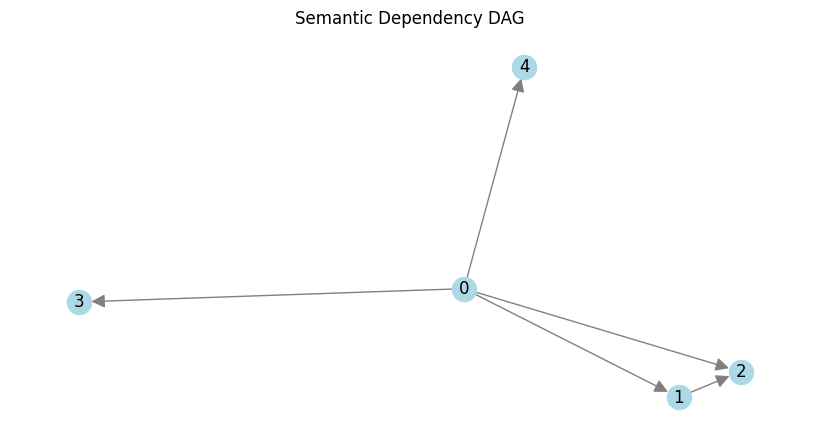

In [37]:
plt.figure(figsize=(8, 4))
pos = nx.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrowsize=20)
plt.title("Semantic Dependency DAG")
plt.show()

## Real Data Example
Now that we have a working setup, we can try this on some synthetic data!

In [40]:
def get_data_loader(dataset_name="wikitext", subset="wikitext-103-raw-v1", split="train"):
    """
    Returns an iterable streaming dataset.
    """
    # streaming=True means we don't download the 100GB+ file to disk
    dataset = load_dataset(dataset_name, subset, split=split, streaming=True)
    return dataset

In [41]:
# Initialize loader
raw_dataset = get_data_loader()

# Create a generator to fetch documents one by one
data_iter = iter(raw_dataset)

README.md: 0.00B [00:00, ?B/s]

Note: you need to run the below cell multiple times until you get something that actually looks like part of a Wikipedia article.

In [89]:
print("Fetching document from Wikitext-103...")
sample = next(data_iter)
doc_text = sample['text']
print(f"\nOriginal Doc Start: {doc_text[:100]}...\n")

Fetching document from Wikitext-103...

Original Doc Start:  The game takes place during the Second Europan War . Gallian Army Squad 422 , also known as " The N...



Generating the permutations!

In [93]:
inputs, sent_data = get_sentence_token_spans(doc_text, tokenizer)
print(f"Detected {len(sent_data)} sentences.")

attn_matrix = extract_sentence_dependency_matrix(model, inputs, sent_data)
dag, permutations = generate_permutations(sent_data, attn_matrix, quantile_threshold=0.5)

print(f"Generated {len(permutations)} permutations (including original).")

Detected 5 sentences.
Generated 5 permutations (including original).


In [94]:
for i, perm in enumerate(permutations[:3]):
    print(f"--- Permutation {i+1} ---")
    reconstructed_text = " ".join([sent_data[idx]['text'] for idx in perm])
    print(reconstructed_text)
    print("")

--- Permutation 1 ---
The game takes place during the Second Europan War . Gallian Army Squad 422 , also known as " The Nameless " , are a penal military unit composed of criminals , foreign deserters , and military offenders whose real names are erased from the records and thereon officially referred to by numbers . The three main characters are No.7 Kurt Irving , an army officer falsely accused of treason who wishes to redeem himself ; Ace No.1 Imca , a female Darcsen heavy weapons specialist who seeks revenge against the Valkyria who destroyed her home ; and No.13 Riela Marcellis , a seemingly jinxed young woman who is unknowingly a descendant of the Valkyria . Together with their fellow squad members , these three are tasked to fight against a mysterious Imperial unit known as Calamity Raven , consisting of mostly Darcsen soldiers . Ordered by the Gallian military to perform the most dangerous missions that the Regular Army and Militia will not do , they are nevertheless up to the 

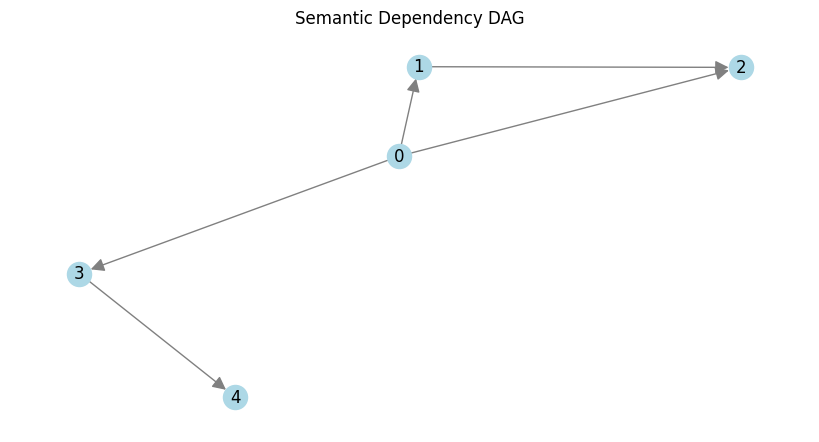

In [96]:
plt.figure(figsize=(8, 4))
pos = nx.spring_layout(dag)
nx.draw(dag, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrowsize=20)
plt.title("Semantic Dependency DAG")
plt.show()

## Training